<a href="https://colab.research.google.com/github/hassen8/emotion_recognition_bias_auditing/blob/master/deepface_on_RAF_GRAD_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to drive then download, unzip the dataset then copy the label file

In [12]:
from google.colab import drive
drive.mount("/content/drive")

ZIP_PATH   = "/content/drive/MyDrive/Image/aligned.zip"
LABEL_PATH = "/content/drive/MyDrive/EmoLabel/list_patition_label.txt"

!unzip -oq "{ZIP_PATH}" -d /content
!cp "{LABEL_PATH}" /content/list_patition_label.txt

IMAGE_DIR = "/content/aligned"
LABEL_FILE = "/content/list_patition_label.txt"

import os
print("IMAGE_DIR exists:", os.path.exists(IMAGE_DIR), IMAGE_DIR)
print("LABEL_FILE exists:", os.path.exists(LABEL_FILE), LABEL_FILE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
IMAGE_DIR exists: True /content/aligned
LABEL_FILE exists: True /content/list_patition_label.txt


#Install and Imports


In [13]:
!pip -q install deepface tqdm

import os, json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from deepface import DeepFace

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    top_k_accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

np.random.seed(0)
tf.random.set_seed(0)

# Canonical label order

In [14]:
EMOTIONS = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

# RAF-DB label mapping: 1..7
RAF_ID_TO_EMO = {
    1: "surprise",
    2: "fear",
    3: "disgust",
    4: "happy",
    5: "sad",
    6: "angry",
    7: "neutral",
}

# Load RAF-DB lables + build file paths

In [15]:
def load_rafdb_df(image_dir, label_file, split="train"):
    df = pd.read_csv(label_file, sep=" ", header=None, names=["filename", "label"])

    if split == "train":
        df = df[df["filename"].str.startswith("train")]
    elif split == "test":
        df = df[df["filename"].str.startswith("test")]
    else:
        raise ValueError("split must be 'train' or 'test'.")

    # aligned naming: train_00001_aligned.jpg
    df["aligned_filename"] = df["filename"].str.replace(".jpg", "_aligned.jpg", regex=False)
    df["file_path"] = df["aligned_filename"].apply(lambda x: os.path.join(image_dir, x))
    df.drop(columns=["aligned_filename"], inplace=True)

    # map RAF numeric to emotion string
    df["emotion_label"] = df["label"].map(RAF_ID_TO_EMO)

    df = df[df["file_path"].apply(os.path.exists)].reset_index(drop=True)

    # sanity
    missing = df["emotion_label"].isna().sum()
    if missing > 0:
        raise RuntimeError(f"{missing} labels could not be mapped. Check label file format.")

    return df

df = load_rafdb_df(IMAGE_DIR, LABEL_FILE, split="train")
print(df.head())
print("N:", len(df))
print(df["emotion_label"].value_counts())


          filename  label                                 file_path  \
0  train_00001.jpg      5  /content/aligned/train_00001_aligned.jpg   
1  train_00002.jpg      5  /content/aligned/train_00002_aligned.jpg   
2  train_00003.jpg      4  /content/aligned/train_00003_aligned.jpg   
3  train_00004.jpg      4  /content/aligned/train_00004_aligned.jpg   
4  train_00005.jpg      5  /content/aligned/train_00005_aligned.jpg   

  emotion_label  
0           sad  
1           sad  
2         happy  
3         happy  
4           sad  
N: 12271
emotion_label
happy       4772
neutral     2524
sad         1982
surprise    1290
disgust      717
angry        705
fear         281
Name: count, dtype: int64


## Quick visualization

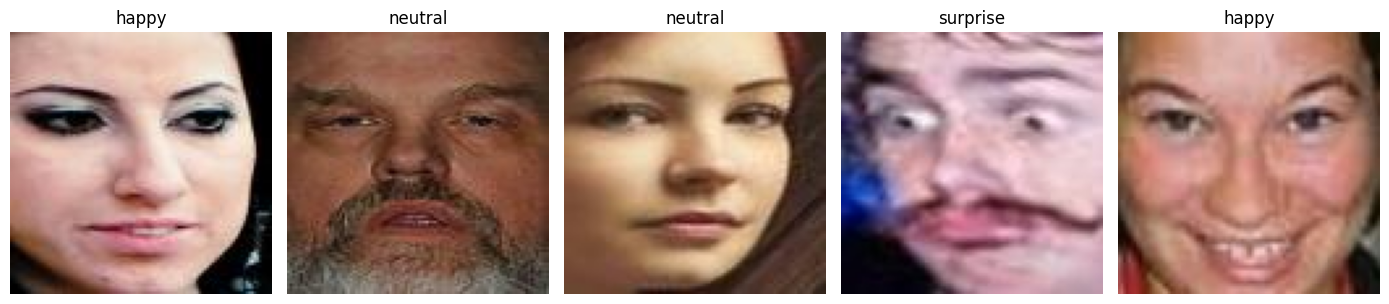

In [17]:
sample = df.sample(5, random_state=0).reset_index(drop=True)

plt.figure(figsize=(14, 3))
for i in range(len(sample)):
    img = cv2.imread(sample.loc[i, "file_path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img_rgb)
    plt.title(sample.loc[i, "emotion_label"])
    plt.axis("off")
plt.tight_layout()
plt.show()

# Run DeepFace emotion predictions

In [19]:
import numpy as np
import json

def make_json_safe(obj):
    if isinstance(obj, dict):
        return {k: make_json_safe(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [make_json_safe(v) for v in obj]
    if isinstance(obj, tuple):
        return [make_json_safe(v) for v in obj]
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj


In [18]:
def deepface_analyze_emotion(path):
    out = DeepFace.analyze(
        img_path=path,
        actions=["emotion"],
        enforce_detection=False
    )
    return out[0]

def extract_proba_from_deepface_entry(entry, emotions=EMOTIONS):
    # DeepFace returns 0..100
    emo_dict = entry["emotion"]
    probs = np.array([emo_dict[e] for e in emotions], dtype=np.float32) / 100.0
    # normalize small drift
    s = probs.sum()
    if s > 0:
        probs = probs / s
    return probs

# -RUn
paths = df["file_path"].tolist()

results = []
y_pred_proba = np.zeros((len(paths), len(EMOTIONS)), dtype=np.float32)

for i, p in enumerate(tqdm(paths)):
    entry = deepface_analyze_emotion(p)
    results.append(entry)
    y_pred_proba[i] = extract_proba_from_deepface_entry(entry, EMOTIONS)

# Save (optional)
OUT_JSON = "/content/drive/MyDrive/deepface_results_raf_train.json"
with open(OUT_JSON, "w") as f:
    json.dump(results, f, indent=2)
print("Saved:", OUT_JSON)

y_pred = np.argmax(y_pred_proba, axis=1)

100%|██████████| 12271/12271 [11:54<00:00, 17.17it/s]


TypeError: Object of type float32 is not JSON serializable

In [21]:
OUT_JSON = "/content/drive/MyDrive/deepface_results_raf_train.json"

serializable_results = make_json_safe(results)

with open(OUT_JSON, "w") as f:
    json.dump(serializable_results, f, indent=2)

print("Saved:", OUT_JSON)
y_pred = np.argmax(y_pred_proba, axis=1)

Saved: /content/drive/MyDrive/deepface_results_raf_train.json


# Metrics (Top-1, Top-3, F1 + confusion matrix)

Top-1 Accuracy:  0.3872
Top-3 Accuracy:  0.6503
F1 (Macro):      0.2171
F1 (Weighted):   0.3718

Per-class report:

              precision    recall  f1-score   support

       angry       0.24      0.43      0.31       705
     disgust       0.18      0.01      0.02       717
        fear       0.04      0.13      0.06       281
       happy       0.75      0.75      0.75      4772
         sad       0.25      0.16      0.19      2524
    surprise       0.04      0.01      0.01      1982
     neutral       0.12      0.31      0.17      1290

    accuracy                           0.39     12271
   macro avg       0.23      0.26      0.22     12271
weighted avg       0.39      0.39      0.37     12271



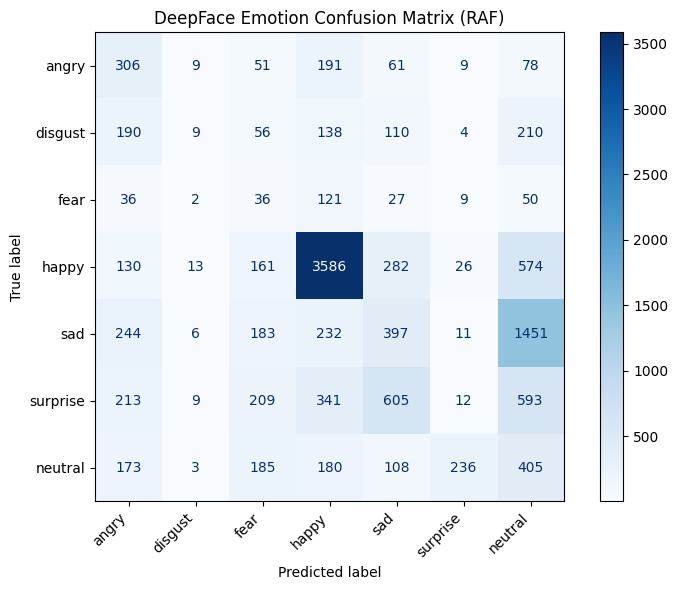

In [22]:
# Ground truth in SAME order
le = LabelEncoder()
le.fit(EMOTIONS)
y_true = le.transform(df["emotion_label"].values)

top1_acc = top_k_accuracy_score(y_true, y_pred_proba, k=1)
top3_acc = top_k_accuracy_score(y_true, y_pred_proba, k=3)
f1_macro = f1_score(y_true, y_pred, average="macro")
f1_weighted = f1_score(y_true, y_pred, average="weighted")

print(f"Top-1 Accuracy:  {top1_acc:.4f}")
print(f"Top-3 Accuracy:  {top3_acc:.4f}")
print(f"F1 (Macro):      {f1_macro:.4f}")
print(f"F1 (Weighted):   {f1_weighted:.4f}")
print("\nPer-class report:\n")
print(classification_report(y_true, y_pred, target_names=EMOTIONS))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EMOTIONS)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("DeepFace Emotion Confusion Matrix (RAF)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Calibration: ECE + Reliability diagram

In [23]:
def compute_ece(y_true, y_prob, n_bins=15):
    confidences = np.max(y_prob, axis=1)
    predictions = np.argmax(y_prob, axis=1)
    accuracies = (predictions == y_true).astype(np.float32)

    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        lo, hi = bin_edges[i], bin_edges[i+1]
        in_bin = (confidences > lo) & (confidences <= hi)
        prop = in_bin.mean()

        if prop > 0:
            acc_bin = accuracies[in_bin].mean()
            conf_bin = confidences[in_bin].mean()
            ece += abs(acc_bin - conf_bin) * prop

    return float(ece)

ece = compute_ece(y_true, y_pred_proba, n_bins=15)
print(f"ECE: {ece:.4f}")

ECE: 0.4350


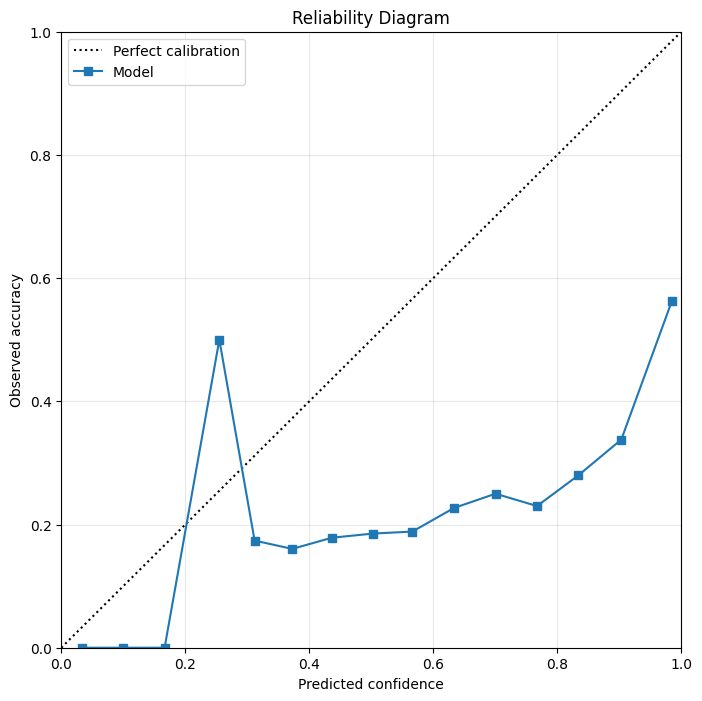

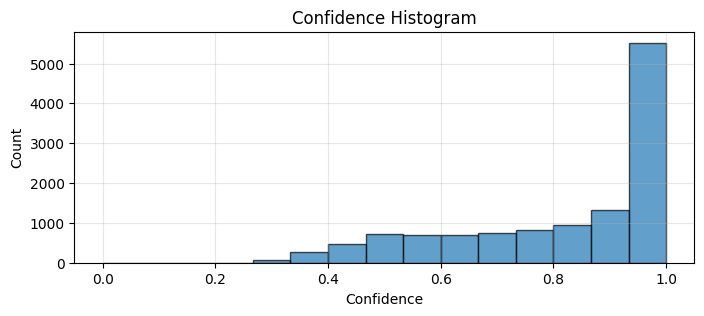

In [24]:
def plot_reliability_diagram(y_true, y_prob, n_bins=15, title="Reliability Diagram"):
    confidences = np.max(y_prob, axis=1)
    predictions = np.argmax(y_prob, axis=1)
    correct = (predictions == y_true)

    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_acc, bin_conf, bin_count = [], [], []

    for i in range(n_bins):
        lo, hi = bin_edges[i], bin_edges[i+1]
        in_bin = (confidences > lo) & (confidences <= hi)
        c = in_bin.sum()
        bin_count.append(c)

        if c > 0:
            bin_acc.append(correct[in_bin].mean())
            bin_conf.append(confidences[in_bin].mean())
        else:
            bin_acc.append(0.0)
            bin_conf.append((lo + hi)/2)

    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], "k:", label="Perfect calibration")
    plt.plot(bin_conf, bin_acc, "s-", label="Model")
    plt.ylabel("Observed accuracy")
    plt.xlabel("Predicted confidence")
    plt.title(title)
    plt.ylim(0, 1); plt.xlim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 3))
    plt.hist(confidences, bins=bin_edges, edgecolor="black", alpha=0.7)
    plt.xlabel("Confidence")
    plt.ylabel("Count")
    plt.title("Confidence Histogram")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_reliability_diagram(y_true, y_pred_proba, n_bins=15)

# **GRAD-CAM EXPERIMENT SECTION**

We apply Grad-CAM (Gradient-weighted Class Activation Mapping) to the DeepFace emotion
model trained on facial expressions. The goal is to understand **which regions of the face**
(eyes, mouth, etc.) the model uses to classify different emotions.

## Imports

In [25]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import Activation, Softmax

# DeepFace emotion model
emotion_client = DeepFace.build_model(task="facial_attribute", model_name="Emotion")
base_model = emotion_client.model
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 44, 44, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 7, 7, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 1, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,485,831 (5.67 MB)

 Trainable params: 1,485,831 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
def build_gradcam_model_from_sequential(base_model):
    gc_input = tf.keras.Input(shape=(48, 48, 1))
    x = gc_input

    target_activation = None
    target_layer_name = None

    for layer in base_model.layers:
        x = layer(x)
        if isinstance(layer, (Conv2D, DepthwiseConv2D, SeparableConv2D)):
            target_activation = x
            target_layer_name = layer.name

    if target_activation is None:
        raise ValueError("No conv-like layer found for Grad-CAM.")

    # detect softmax at end -> try logits
    last = base_model.layers[-1]
    use_logits = isinstance(last, Softmax) or (
        isinstance(last, Activation) and getattr(last, "activation", None) == tf.keras.activations.softmax
    )

    if use_logits:
        y = gc_input
        last_conv = None
        for layer in base_model.layers[:-1]:
            y = layer(y)
        logits = y
        print(f"[Grad-CAM] Target conv: {target_layer_name} | Using logits (pre-softmax).")
        outputs = [target_activation, logits]
    else:
        print(f"[Grad-CAM] Target conv: {target_layer_name} | Using model output (likely probs).")
        outputs = [target_activation, x]

    return tf.keras.Model(inputs=gc_input, outputs=outputs, name="gradcam_model")

gradcam_model = build_gradcam_model_from_sequential(base_model)

# sanity
dummy = tf.zeros((1, 48, 48, 1), dtype=tf.float32)
fmaps, scores = gradcam_model(dummy, training=False)
print("Feature maps:", fmaps.shape, "Scores:", scores.shape)

[Grad-CAM] Target conv: conv2d_4 | Using model output (likely probs).
Feature maps: (1, 3, 3, 128) Scores: (1, 7)


Next, we build a functional model for Grad-CAM by replaying base_model layers on a new INput tensor, while remembering the last conv like activation.

## Preprocess RAF images for the emotion model

For GRAD-CAM we need to feed images in exactly the format the model expects


*   Grayscale faces
*   48x48 resolution

*   Normalized pixel values ([0,1])
*   Input shape (1,48,48,1) - (batch, height, width, channel)

We will therefore convert the RAF-DB aligned BGR images to this format before feeding them into the Grad-CAM pipeline.





In [27]:
def preprocess_for_emotion(img_bgr):
    """
    Convert RAF aligned face image into a tensor of shape
     (1, 48, 48, 1) for the emotion model.
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # Resize to 48x48
    resized = cv2.resize(gray, (48, 48), interpolation=cv2.INTER_AREA)
    # Normalize to [0,1]
    norm = resized.astype("float32") / 255.0
    # Add channel + batch dims: (1, 48, 48, 1)
   # tensor = norm.reshape(1, 48, 48, 1)
    return norm.reshape(1, 48, 48, 1)

# Grad-CAM heatmap function

### Grad-CAM on DeepFace Emotion Model

Given a CNN and a target class $c$ (e.g., "happy"), Grad-CAM operates on the **last
convolutional feature maps** $A^k$ (where $k$ indexes channels) and the class
score $y^c$ (the logit or pre-softmax value for class $c$).

Formally, let the preprocessed input be
$$
x \in \mathbb{R}^{1 \times 48 \times 48 \times 1}.
$$

1. **Forward pass**

   We run a forward pass through `gradcam_model` to obtain:

   - $A^k$: feature maps from the last convolutional layer
   - $y^c$: class scores for all emotion classes

2. **Select target class**

   We choose the target class $c$ either as:
   - the predicted class $c = \arg\max y$, or  
   - a manually specified class index.

3. **Gradients w.r.t. feature maps**

   Using automatic differentiation (`tf.GradientTape`), we compute the gradient
   of the target class score with respect to each feature map:

   $$
   \frac{\partial y^c}{\partial A^k_{ij}} \, .
   $$

4. **Channel importance weights**

   We spatially average these gradients over the feature map to obtain a single
   **importance weight** $\alpha_k^c$ per channel:

   $$
   \alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A^k_{ij}}
   $$

   where $Z$ is the number of spatial locations (height $\times$ width).

5. **Grad-CAM map**

   We then form the Grad-CAM map as a weighted sum of the feature maps,
   followed by a ReLU to keep only positive contributions:

   $$
   L_{\text{Grad-CAM}}^c = \mathrm{ReLU}\left( \sum_k \alpha_k^c A^k \right).
   $$

6. **Normalization and upsampling**

   Finally, we normalize $L_{\text{Grad-CAM}}^c$ to the range $[0,1]$ and
   upsample it to the original image resolution to obtain a **heatmap**
   showing which pixels contribute most to class $c$.

In our project, we apply this procedure to a subset of RAF-DB samples to inspect how
DeepFace’s internal attention patterns relate to facial regions (eyes, mouth, etc.)
and to known differences in neurodivergent expression (e.g., reduced eye contact,
flatter affect).


In [28]:
def make_gradcam_heatmap(img_tensor, class_index=None):
    img_tensor = tf.cast(img_tensor, tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, scores = gradcam_model(img_tensor, training=False)
        tape.watch(conv_outputs)

        if class_index is None:
            class_index = int(tf.argmax(scores[0]).numpy())
        else:
            class_index = int(class_index)

        class_score = scores[0, class_index]

    grads = tape.gradient(class_score, conv_outputs)
    if grads is None:
        raise RuntimeError("Gradients are None. Target layer might be disconnected.")

    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))  # (1, C)
    conv_outputs = conv_outputs[0]                      # (H, W, C)
    pooled_grads = pooled_grads[0]                      # (C,)

    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.nn.relu(heatmap)

    heatmap = heatmap - tf.reduce_min(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)

    return heatmap.numpy(), scores.numpy()[0]

# Visualizing Grad-CAM on RAF images

We now apply Grad-CAM to RAF-DB samples. For each image:

1. We load the pre-aligned BGR face from RAF-DB.
2. We preprocess it to (1, 48, 48, 1) for the emotion model.
3. We compute the Grad-CAM heatmap.
4. We upsample the heatmap to the original image size and overlay it
   with a color map to highlight important regions.

This gives a qualitative view of which facial regions (eyes, mouth, nose etc.)
the model uses to classify different emotions.

### Overlay + example visualization


In [29]:
def overlay_gradcam(img_bgr, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    H, W = img_bgr.shape[:2]
    hm = cv2.resize(heatmap, (W, H), interpolation=cv2.INTER_LINEAR)
    hm_uint8 = np.uint8(255 * np.clip(hm, 0, 1))

    hm_bgr = cv2.applyColorMap(hm_uint8, colormap)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    hm_rgb = cv2.cvtColor(hm_bgr, cv2.COLOR_BGR2RGB)

    return cv2.addWeighted(img_rgb, 1 - alpha, hm_rgb, alpha, 0)

## Single example

image_data shape: (12271, 100, 100, 3) uint8
True: sad
Pred: neutral
Scores: {'angry': np.float32(0.017), 'disgust': np.float32(0.0), 'fear': np.float32(0.005), 'happy': np.float32(0.001), 'sad': np.float32(0.253), 'surprise': np.float32(0.0), 'neutral': np.float32(0.724)}


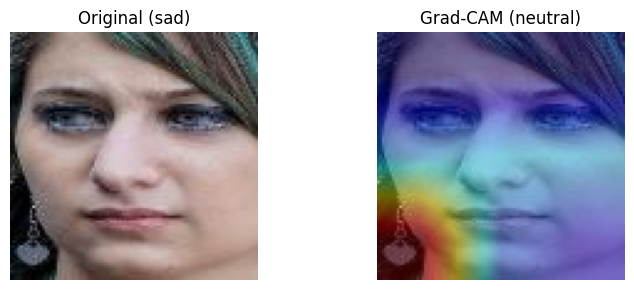

In [31]:
# Load a few images once (BGR)
image_data = []
for p in df["file_path"]:
    img = cv2.imread(p)
    if img is None:
        raise RuntimeError(f"Failed to load image: {p}")
    image_data.append(img)

image_data = np.stack(image_data, axis=0)  # shape: (N, H, W, 3)
print("image_data shape:", image_data.shape, image_data.dtype)

idx = 0
img_bgr = image_data[idx]
true_label = df.loc[idx, "emotion_label"]

img_tensor = preprocess_for_emotion(img_bgr)
heatmap, scores = make_gradcam_heatmap(img_tensor)

pred_idx = int(np.argmax(scores))
pred_label = EMOTIONS[pred_idx]

print("True:", true_label)
print("Pred:", pred_label)
print("Scores:", dict(zip(EMOTIONS, np.round(scores, 3))))

overlay_img = overlay_gradcam(img_bgr, heatmap)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.title(f"Original ({true_label})")
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM ({pred_label})")
plt.imshow(overlay_img)
plt.axis("off")

plt.tight_layout()
plt.show()

## Batch Grad-CAM


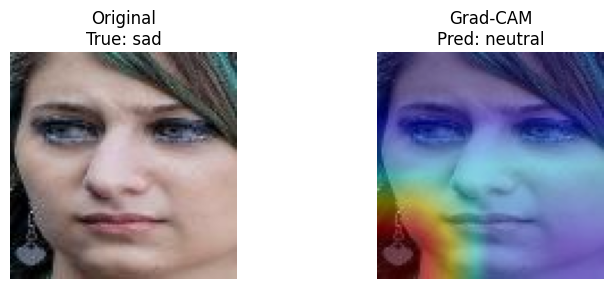

Saved: /content/gradcam_outputs/gradcam_0_true-sad_pred-neutral.png


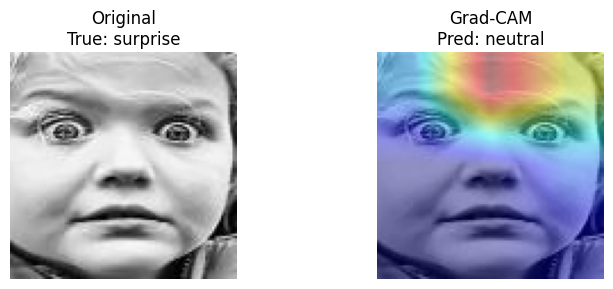

Saved: /content/gradcam_outputs/gradcam_5_true-surprise_pred-neutral.png


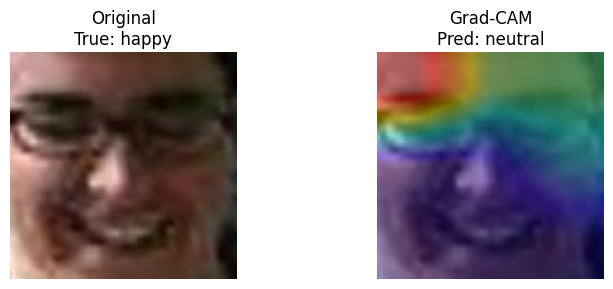

Saved: /content/gradcam_outputs/gradcam_10_true-happy_pred-neutral.png


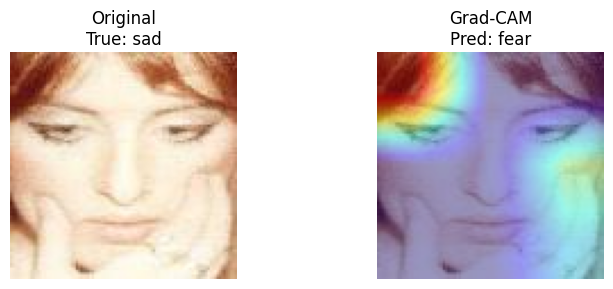

Saved: /content/gradcam_outputs/gradcam_25_true-sad_pred-fear.png


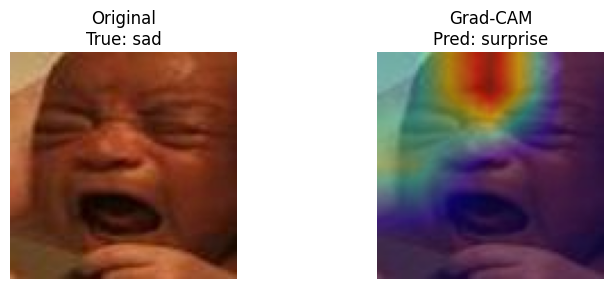

Saved: /content/gradcam_outputs/gradcam_40_true-sad_pred-surprise.png


In [32]:
os.makedirs("/content/gradcam_outputs", exist_ok=True)

def show_and_save_gradcam(idx, save=True):
    img_bgr = image_data[idx]
    true_label = df.loc[idx, "emotion_label"]

    img_tensor = preprocess_for_emotion(img_bgr)
    heatmap, scores = make_gradcam_heatmap(img_tensor)

    pred_idx = int(np.argmax(scores))
    pred_label = EMOTIONS[pred_idx]

    overlay_img = overlay_gradcam(img_bgr, heatmap)

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.title(f"Original\nTrue: {true_label}")
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM\nPred: {pred_label}")
    plt.imshow(overlay_img)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    if save:
        out = f"/content/gradcam_outputs/gradcam_{idx}_true-{true_label}_pred-{pred_label}.png"
        cv2.imwrite(out, cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR))
        print("Saved:", out)

for idx in [0, 5, 10, 25, 40]:
    show_and_save_gradcam(idx, save=True)

## **Aggregated Grad-CAM Analysis (Beyond Single Images)**

### **Per-emotion Average Grad-CAM Heatmaps**

### Per-emotion Average Grad-CAM Heatmaps

Single Grad-CAM maps are useful but noisy. To capture **systematic patterns**, we compute an **average Grad-CAM heatmap per emotion**.

For each image in a subset:

1. We compute the Grad-CAM heatmap $H^{(n)}$ for the model's **predicted** class.
2. We group heatmaps by predicted emotion (e.g., "happy", "sad").
3. For each emotion \( e \), we compute the **mean heatmap**:

$$
\bar{H}_e = \frac{1}{N_e} \sum_{n \in \mathcal{I}_e} H^{(n)}
$$

where:
- $ \mathcal{I}_e $ is the set of indices whose predicted label is $e$,  
- $ N_e = |\mathcal{I}_e| $ is the number of samples in that set.  

TThe resulting $ \bar{H}_e $ shows the canonical attention pattern for emotion $e$ (for example, a mouth-centric pattern for "happy").

In [33]:
from collections import defaultdict

N_SAMPLES = 500
CONF_TH = 0.6

rng = np.random.default_rng(0)
subset_indices = rng.choice(len(image_data), size=min(N_SAMPLES, len(image_data)), replace=False)

per_emotion_heatmaps = defaultdict(list)
counts_total = defaultdict(int)

for idx in tqdm(subset_indices):
    img_bgr = image_data[idx]
    img_tensor = preprocess_for_emotion(img_bgr)
    heatmap, scores = make_gradcam_heatmap(img_tensor)

    pred_idx = int(np.argmax(scores))
    pred_label = EMOTIONS[pred_idx]
    conf = float(np.max(scores))

    counts_total[pred_label] += 1
    if conf >= CONF_TH:
        per_emotion_heatmaps[pred_label].append(heatmap)

print("Total sampled per label:", dict(counts_total))
print("Kept (conf>=th):", {k: len(v) for k, v in per_emotion_heatmaps.items()})

100%|██████████| 500/500 [00:21<00:00, 23.35it/s]

Total sampled per label: {'neutral': 113, 'sad': 86, 'fear': 38, 'surprise': 13, 'happy': 206, 'disgust': 4, 'angry': 40}
Kept (conf>=th): {'sad': 62, 'fear': 26, 'surprise': 10, 'happy': 189, 'neutral': 92, 'angry': 29, 'disgust': 1}


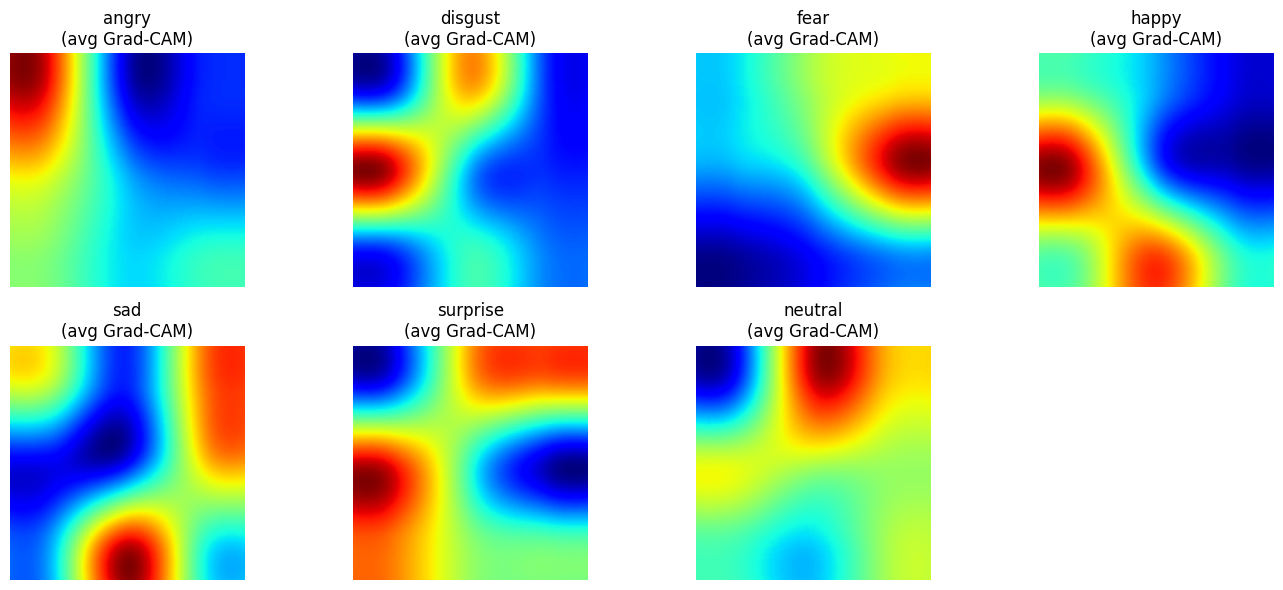

In [34]:
avg_heatmaps = {}
for label, hmaps in per_emotion_heatmaps.items():
    if len(hmaps) == 0:
        continue
    avg_heatmaps[label] = np.mean(np.stack(hmaps, axis=0), axis=0)

plt.figure(figsize=(14, 6))
for i, label in enumerate(EMOTIONS):
    if label not in avg_heatmaps:
        continue
    vis = cv2.resize(avg_heatmaps[label], (128, 128), interpolation=cv2.INTER_CUBIC)
    vis = (vis - vis.min()) / (vis.max() - vis.min() + 1e-8)

    plt.subplot(2, 4, i+1)
    plt.title(f"{label}\n(avg Grad-CAM)")
    plt.imshow(vis, cmap="jet")
    plt.axis("off")

plt.tight_layout()
plt.show()

### **Region-level atention**

Grad-CAM heatmaps $H \in \mathbb{R}^{H \times W}$
 capture where the model looks,
but we need want **numeric** summaries.

We define approximate regions on the face (eyes, mouth, nose/center, other)
using fixed relative coordinates, assuming RAF-DB aligned faces.

Given a resized heatmap \( H \) over the original image resolution, let:

- $R_{\text{eyes}}$ = set of pixels in the eyes region  
- $R_{\text{mouth}}$ = set of pixels in the mouth region  
- $R_{\text{nose}}$ = set of pixels in a central band (nose/center)  
- $R_{\text{other}}$ = all remaining pixels  


We define the **attention fraction** for each region as:

$$
f_{\text{region}} = \frac{\sum_{(i,j) \in R_{\text{region}}} H_{ij}}
                         {\sum_{i,j} H_{ij}}
$$

These fractions satisfy:

$$
f_{\text{eyes}} + f_{\text{mouth}} + f_{\text{nose}} + f_{\text{other}} = 1
$$

By aggregating these fractions per emotion, we can say, for example:

- "On average, 65% of 'happy' attention is on the mouth region,"
- "For 'sad', attention shifts to the eye region,"
- etc.

This forms a quantitative link between model behavior and neurotypical facial
expression patterns (e.g., strong mouth-based happiness).


The following cell defines region definitions on the face.

In [35]:
def _clip_box(x1, y1, x2, y2, W, H):
    x1 = int(np.clip(x1, 0, W - 1))
    x2 = int(np.clip(x2, 0, W))
    y1 = int(np.clip(y1, 0, H - 1))
    y2 = int(np.clip(y2, 0, H))
    if x2 <= x1: x2 = min(W, x1 + 1)
    if y2 <= y1: y2 = min(H, y1 + 1)
    return x1, y1, x2, y2

In [36]:
def get_face_regions(img_bgr):
    H, W = img_bgr.shape[:2]

    eye_y1, eye_y2 = 0.18 * H, 0.42 * H
    eye_x1, eye_x2 = 0.18 * W, 0.82 * W

    nose_y1, nose_y2 = 0.35 * H, 0.65 * H
    nose_x1, nose_x2 = 0.35 * W, 0.65 * W

    mouth_y1, mouth_y2 = 0.62 * H, 0.88 * H
    mouth_x1, mouth_x2 = 0.25 * W, 0.75 * W

    return {
        "eyes":  _clip_box(eye_x1,  eye_y1,  eye_x2,  eye_y2,  W, H),
        "nose":  _clip_box(nose_x1, nose_y1, nose_x2, nose_y2, W, H),
        "mouth": _clip_box(mouth_x1, mouth_y1, mouth_x2, mouth_y2, W, H),
    }

This will compute region fractions for one sample.

In [37]:
def compute_region_fractions(img_bgr, heatmap, eps=1e-8, priority=("eyes","nose","mouth")):
    """
      Compute region attention fractions using mutually-exclusive region masks
      to avoid double counting.

      Args:
          img_bgr: (H,W,3) BGR image
          heatmap: 2D array (h,w) Grad-CAM heatmap in [0,1] (or >=0)
          eps: small constant
          priority: order used to resolve overlaps (first wins)

      Returns:
          fractions dict with keys: eyes, nose, mouth, other
          (sums to ~1.0)
    """
    H, W = img_bgr.shape[:2]
    hm = cv2.resize(heatmap, (W, H), interpolation=cv2.INTER_LINEAR)
    hm = np.maximum(hm.astype(np.float32), 0.0)

    total = float(hm.sum()) + eps
    regions = get_face_regions(img_bgr)

    assigned = np.zeros((H, W), dtype=bool)
    region_sums = {}

    for name in priority:
        x1, y1, x2, y2 = regions[name]
        mask = np.zeros((H, W), dtype=bool)
        mask[y1:y2, x1:x2] = True
        mask = mask & (~assigned)
        assigned |= mask
        region_sums[name] = float(hm[mask].sum())

    other_sum = float(hm[~assigned].sum())
    fracs = {k: v/total for k, v in region_sums.items()}
    fracs["other"] = other_sum/total

    s = sum(fracs.values())
    if s > 0:
        for k in fracs:
            fracs[k] /= s

    return fracs


## Build attention dataframe

In [38]:
records = []
SUBSET = subset_indices[:200]  # adjust

for idx in tqdm(SUBSET):
    img_bgr = image_data[idx]
    true_label = df.loc[idx, "emotion_label"]

    img_tensor = preprocess_for_emotion(img_bgr)
    heatmap, scores = make_gradcam_heatmap(img_tensor)

    pred_idx = int(np.argmax(scores))
    pred_label = EMOTIONS[pred_idx]

    fracs = compute_region_fractions(img_bgr, heatmap)

    records.append({
        "idx": idx,
        "true_label": true_label,
        "pred_label": pred_label,
        "correct": int(true_label == pred_label),
        "eyes_frac": fracs["eyes"],
        "nose_frac": fracs["nose"],
        "mouth_frac": fracs["mouth"],
        "other_frac": fracs["other"],
    })

attention_df = pd.DataFrame(records)
attention_df.head()

100%|██████████| 200/200 [00:12<00:00, 15.64it/s]


,idx,true_label,pred_label,correct,eyes_frac,nose_frac,mouth_frac,other_frac
0,9829,neutral,neutral,1,0.059734,0.052546,0.306869,0.580850
1,6441,sad,sad,1,0.173564,0.027100,0.023172,0.776163
2,768,surprise,fear,0,0.174714,0.072984,0.118993,0.633309
3,10394,neutral,sad,0,0.163343,0.121336,0.157118,0.558203
4,10759,neutral,surprise,0,0.076815,0.129730,0.306198,0.487258


### Plot stacked bar per predicted

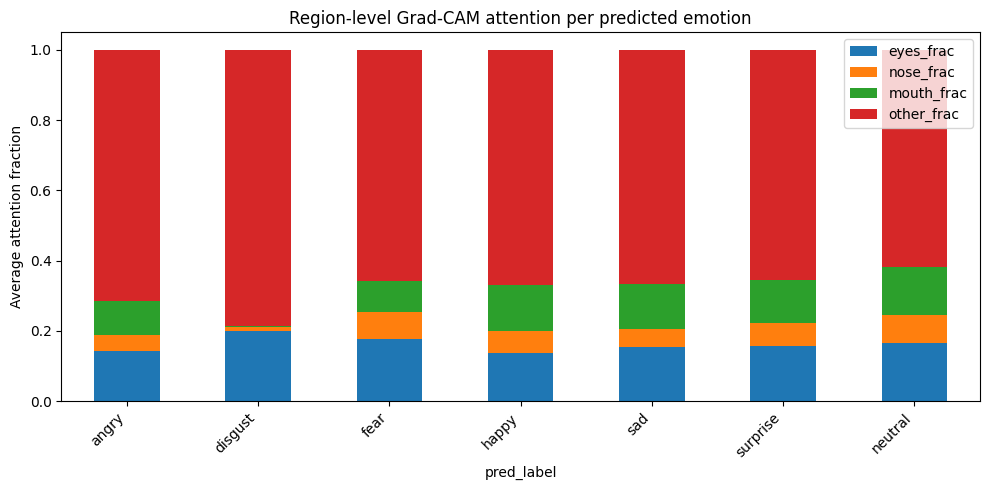

In [39]:
avg_by_pred = attention_df.groupby("pred_label")[["eyes_frac","nose_frac","mouth_frac","other_frac"]].mean()
avg_by_pred = avg_by_pred.reindex(EMOTIONS)

ax = avg_by_pred.plot(kind="bar", stacked=True, figsize=(10, 5))
plt.ylabel("Average attention fraction")
plt.title("Region-level Grad-CAM attention per predicted emotion")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Debugging

Region attention fractions (exclusive):
  eyes : 0.0778
  nose : 0.0852
  mouth: 0.1642
  other: 0.6729
  sum  : 1.0000


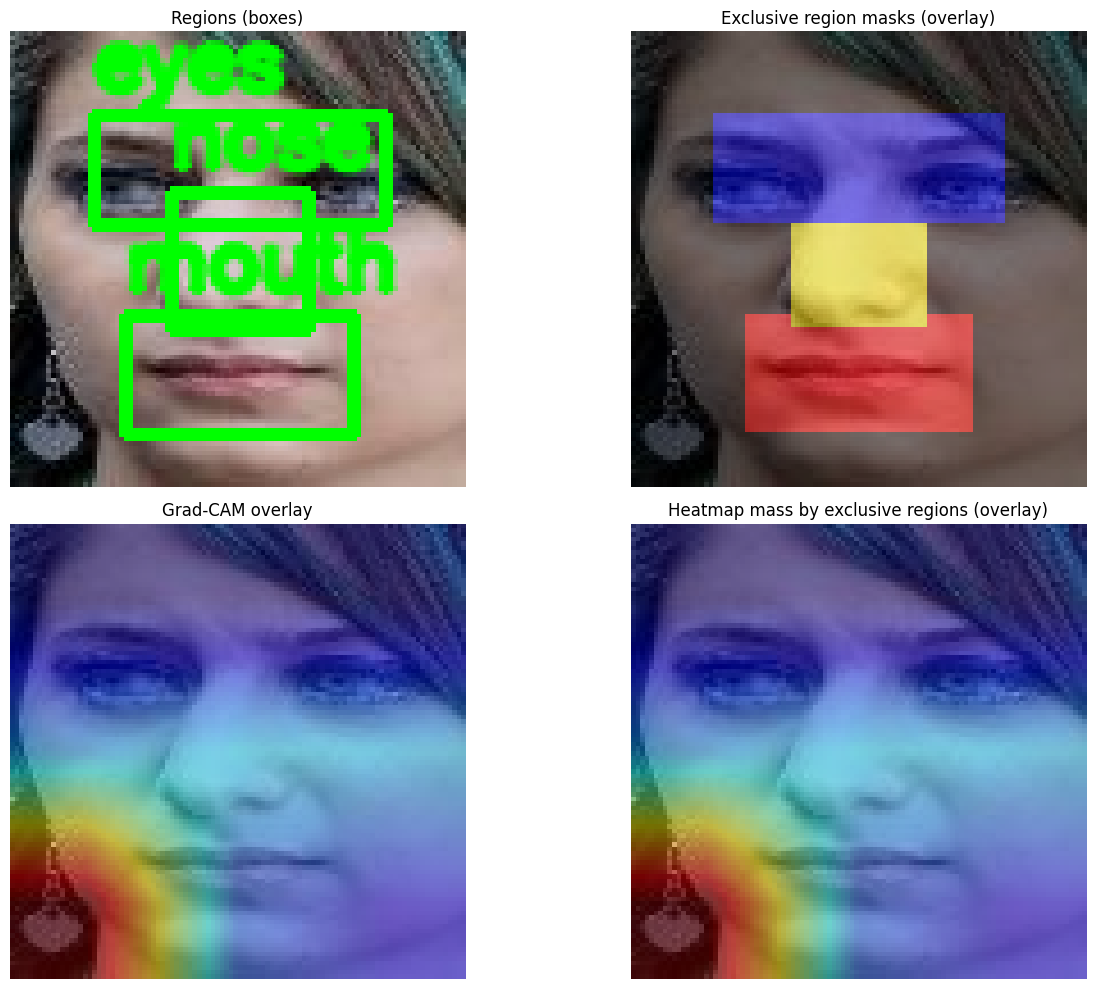

In [40]:
def visualize_regions_and_attention(img_bgr, heatmap, priority=("eyes","nose","mouth"), alpha=0.45):
    H, W = img_bgr.shape[:2]

    hm = cv2.resize(heatmap, (W, H), interpolation=cv2.INTER_LINEAR).astype(np.float32)
    hm = np.maximum(hm, 0.0)
    hm_norm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)

    regions = get_face_regions(img_bgr)

    assigned = np.zeros((H, W), dtype=bool)
    masks = {}
    for name in priority:
        x1, y1, x2, y2 = regions[name]
        m = np.zeros((H, W), dtype=bool)
        m[y1:y2, x1:x2] = True
        m = m & (~assigned)
        assigned |= m
        masks[name] = m
    masks["other"] = ~assigned

    img_boxes = img_bgr.copy()
    for name, (x1, y1, x2, y2) in regions.items():
        cv2.rectangle(img_boxes, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img_boxes, name, (x1, max(0, y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_boxes_rgb = cv2.cvtColor(img_boxes, cv2.COLOR_BGR2RGB)

    region_colors_bgr = {
        "eyes":  (255, 0, 0),
        "nose":  (0, 255, 255),
        "mouth": (0, 0, 255),
        "other": (0, 0, 0),
    }

    mask_vis = np.zeros((H, W, 3), dtype=np.uint8)
    for name, m in masks.items():
        mask_vis[m] = region_colors_bgr[name]
    mask_vis_rgb = cv2.cvtColor(mask_vis, cv2.COLOR_BGR2RGB)
    mask_overlay = cv2.addWeighted(img_rgb, 1-alpha, mask_vis_rgb, alpha, 0)

    cam_overlay = overlay_gradcam(img_bgr, hm_norm, alpha=alpha)

    region_mass = np.zeros((H, W), dtype=np.float32)
    for name, m in masks.items():
        region_mass[m] = hm_norm[m]
    region_mass_rgb = cv2.applyColorMap(np.uint8(255 * region_mass), cv2.COLORMAP_JET)
    region_mass_rgb = cv2.cvtColor(region_mass_rgb, cv2.COLOR_BGR2RGB)
    region_mass_overlay = cv2.addWeighted(img_rgb, 1-alpha, region_mass_rgb, alpha, 0)

    fracs = compute_region_fractions(img_bgr, heatmap, priority=priority)
    print("Region attention fractions (exclusive):")
    for k in ["eyes","nose","mouth","other"]:
        print(f"  {k:5s}: {fracs[k]:.4f}")
    print(f"  sum  : {sum(fracs.values()):.4f}")

    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1); plt.title("Regions (boxes)"); plt.imshow(img_boxes_rgb); plt.axis("off")
    plt.subplot(2, 2, 2); plt.title("Exclusive region masks (overlay)"); plt.imshow(mask_overlay); plt.axis("off")
    plt.subplot(2, 2, 3); plt.title("Grad-CAM overlay"); plt.imshow(cam_overlay); plt.axis("off")
    plt.subplot(2, 2, 4); plt.title("Heatmap mass by exclusive regions (overlay)"); plt.imshow(region_mass_overlay); plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example call
idx = 0
img_bgr = image_data[idx]
img_tensor = preprocess_for_emotion(img_bgr)
heatmap, scores = make_gradcam_heatmap(img_tensor)
visualize_regions_and_attention(img_bgr, heatmap)

# **Results analysis**

We used the DeepFace emotion model directly and attached a Grad-CAM pipeline to
its last convolutional layer. For each RAF-DB image, we fed the aligned face through the same preprocessing as DeepFace’s emotion pipeline, obtained the model’s predicted emotion, and then computed the gradient of that class score with respect to the feature maps of the last conv layer. We averaged these gradients to get channel-wise importance weights, we then combined them with the feature maps, and applied ReLU to obtain a class-specific importance map. Then after up sampling this to the input resolution and overlaying it on the original face, we obtained heatmaps that show which face regions the model relies on when classifying emotions.

We then compared these attention patters like for example the strong focus on
the mouth for "happy" and the heavy reliance on the eye region for some emotions, with literature on neurodivergent expression patters, such as reduced or minimal eue contact and flatter affect. this provides us with a concrete evidence that the model's internal logic is primarily aligned with neurotypical expressive normals which can be problematic, inducing bias to neurodireverse individuals.

# **References**

[1] R. R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh, and D. Batra,  
“Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization,”  
in *Proc. IEEE Int. Conf. Computer Vision (ICCV)*, 2017.  
Available: https://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf

[2] S. Li, W. Deng, and J. Du,  
“Reliable Crowdsourcing and Deep Locality-Preserving Learning for Expression Recognition in the Wild,”  
in *Proc. IEEE Conf. Computer Vision and Pattern Recognition (CVPR)*, 2017, pp. 2584–2593.  
(Original RAF-DB paper)  
Available: https://openaccess.thecvf.com/content_cvpr_2017/papers/Li_Reliable_Crowdsourcing_and_CVPR_2017_paper.pdf

[3] E. Barsoum, C. Zhang, C. Canton Ferrer, and Z. Zhang,  
“Training Deep Networks for Facial Expression Recognition with Crowd-Sourced Label Distribution,”  
in *Proc. 18th ACM Int. Conf. on Multimodal Interaction (ICMI)*, 2016.  
(Original FER+ paper)  
Preprint available: https://arxiv.org/abs/1608.01041

[4] Microsoft,  
“FER+: New Label Annotations for the FER2013 Dataset,”  
GitHub repository, 2016–.  
Available: https://github.com/microsoft/FERPlus

[5] S. Li, W. Deng,  
“Real-world Affective Faces Database (RAF-DB),”  
Dataset website, Beijing University of Posts and Telecommunications.  
Available: http://www.whdeng.cn/RAF/model1.html

[6] S. Serengil and A. Ozpinar,  
“DeepFace: A Lightweight Face Recognition and Facial Attribute Analysis (Age, Gender, Emotion and Race) Library for Python,”  
GitHub repository, 2017–.  
Available: https://github.com/serengil/deepface

[7] C. Guo, G. Pleiss, Y. Sun, and K. Q. Weinberger,  
“On Calibration of Modern Neural Networks,”  
in *Proc. 34th Int. Conf. on Machine Learning (ICML)*, 2017.  
(Defines Expected Calibration Error and reliability diagrams.)  
Available: https://proceedings.mlr.press/v70/guo17a/guo17a.pdf

[8] Z. Lian, Y. Li, J.-H. Tao, J. Huang, and M.-Y. Niu,  
“Expression Analysis Based on Face Regions in Real-world Conditions,”  
arXiv preprint, 2019.  
(Analyzes contribution of different face areas to different emotions, using CAM/Grad-CAM.)  
Available: https://arxiv.org/abs/1911.05188

[9] K. Kärkkäinen and J. Joo,  
“FairFace: Face Attribute Dataset for Balanced Race, Gender, and Age,”  
in *Proc. IEEE/CVF Winter Conf. on Applications of Computer Vision (WACV)*, 2021.  
Available: https://openaccess.thecvf.com/content/WACV2021/papers/Karkkainen_FairFace_Face_Attribute_Dataset_for_Balanced_Race_Gender_and_Age_WACV_2021_paper.pdf  
Dataset GitHub: https://github.com/joojs/fairface

[10] C. T. Keating and co-authors,  
“Facial Expression Production and Recognition in Autism Spectrum Disorders,”  
in *Child and Adolescent Psychiatric Clinics of North America*, vol. 29, no. 3, 2020, pp. 557–573.  
(Review on facial expression production/recognition in autism.)  
Available: https://www.childpsych.theclinics.com/article/S1056-4993(20)30018-3/fulltext

[11] High-Level Expert Group on Artificial Intelligence, European Commission,  
“Ethics Guidelines for Trustworthy AI,” 2019.  
Available: https://digital-strategy.ec.europa.eu/en/library/ethics-guidelines-trustworthy-ai


### Additional Web Resources

- DeepFace library documentation and examples:  
  https://github.com/serengil/deepface

- Overview of RAF-DB:  
  http://www.whdeng.cn/RAF/model1.html

- FER+ annotations and usage examples:  
  https://github.com/microsoft/FERPlus

- EU Trustworthy AI main page:  
  https://digital-strategy.ec.europa.eu/en/library/ethics-guidelines-trustworthy-ai


Authored by

*   Hassen Said Ali

*   Luwam Major Kefali
*   Hilina Fissha Woreta



